# 02 - Data from the Web

In [1]:
import pandas as pd
import numpy as np
from requests import get
from bs4 import BeautifulSoup as bs
import json
import re

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns # interface for statical data visualization
from IPython.display import display

sns.set_context('notebook')
pd.options.mode.chained_assignment = None  # default='warn', Mutes warnings when copying a slice from a DataFrame.import seaborn as sns

## Useful functions

In [2]:
def clean_number(n):
    return int(''.join(filter(lambda c: c.isdigit(), n)))

def select_or_zero(soup, select):
    selection = soup.select(select)
    if len(selection) == 0:
        return np.nan
    return clean_number(selection[0].text)

def select_url(soup, select):
    selection = soup.select(select)
    if len(selection) == 0:
        return np.nan
    return clean_url(selection[0]['href'])

def normalize_name(name):
    name = str(name)
    name = re.sub('\(.*\)','', name)
    name = re.sub('^The','', name)
    name = re.sub('^É','E', name)
    name = name.replace('–', '-')
    return name.title().strip()

def map_name(name):
    if name == 'Ucl':
        return 'University College London'
    if name == 'Eth Zurich - Swiss Federal Institute Of Technology':
        return 'Eth Zurich - Swiss Federal Institute Of Technology Zurich'
    if name == "King’S College London" or name == "King'S College London":
        return "King's College London"
    if name == 'University Of Freiburg':
        return 'Albert-Ludwigs-Universitaet Freiburg'
    if name == 'Autonomous University Of Barcelona':
        return 'Universitat Autònoma De Barcelona'
    if name == 'Free University Of Berlin':
        return 'Freie Universitaet Berlin'
    if name == 'Heidelberg University':
        return 'Ruprecht-Karls-Universität Heidelberg'
    if name == 'Humboldt University Of Berlin':
        return 'Humboldt-Universität Zu Berlin'
    if name == 'Karlsruhe Institute Of Technology':
        return 'Kit, Karlsruhe Institute Of Technology'
    if name == 'Korea Advanced Institute Of Science And Technology':
        return 'Kaist - Korea Advanced Institute Of Science & Technology'
    if name == 'Pierre And Marie Curie University':
        return 'Université Pierre Et Marie Curie'
    if name == 'Scuola Superiore Sant’Anna':
        return "Scuola Superiore Sant'Anna Pisa Di Studi Universitari E Di Perfezionamento"
    if name == 'Technical University Of Berlin':
        return 'Technische Universität Berlin'
    if name == 'Trinity College Dublin, The University Of Dublin':
        return 'Trinity College Dublin'   
    if name == 'University Of Montreal':
        return 'Université De Montréal'
    if name ==  'University Of North Carolina, Chapel Hill':
        return 'University Of North Carolina At Chapel Hill'
    if name == 'University Of Tübingen':
        return 'Eberhard Karls Universität Tübingen'
    if name == 'Wageningen University & Research':
        return 'Wageningen University'
    if name == 'Washington University In St Louis':
        return 'Washington University In St. Louis'
    if name == 'Lmu Munich':
        return 'Ludwig-Maximilians-Universität München'
    return name

## Question 1:  TopUniversities website

By inspecting the top universities website with Postman interceptor, we noticed that the actual ranking is loaded from a json file. The json contains the university name, its rank, its country. We can easily extract the first 200 universities from this json.

We are still missing some data at this point, such as the total number of faculty members, the number of international faculty members, the total number of students and the number of international students.

We can only extract these informations from the university description page, also given in the json. What we did is loading the description page and then, using css selector, we selected the correct div containing the value and extracted it.

In [7]:
def get_stats(directory):
    res = get('https://www.topuniversities.com'+directory)
    soup = bs(res.text, "lxml")
    faculty_total = select_or_zero(soup, '.total .text .number')
    faculty_inter = select_or_zero(soup, '.inter .text .number')
    student_total = select_or_zero(soup, '.student .number')
    student_inter = select_or_zero(soup, '.inter .progress-bar-info .number')
    return faculty_total, faculty_inter, student_total, student_inter

def prepare_uni_data_tu(uni):
    uni_infos = dict()
    uni_infos['Name'] = map_name(normalize_name(uni['title']))
    uni_infos['Rank Top Universities'] = clean_number(uni['rank_display'])
    uni_infos['Country'] = uni['country'].strip()
    uni_infos['Region'] = uni['region'].strip()
    uni_infos['Total faculty members'], \
    uni_infos['International faculty members'], \
    uni_infos['Total students'], \
    uni_infos['International students'] = get_stats(uni['url'])
    return uni_infos

res = get('https://www.topuniversities.com/sites/default/files/qs-rankings-data/357051.txt?_=1508338164061', 'html')
json_ranking_tu = json.loads(res.text)['data']
json_ranking_tu_top = sorted(json_ranking_tu, key=lambda k: clean_number(k['rank_display']))[:200]
df_tu = pd.DataFrame(list(map(prepare_uni_data_tu,json_ranking_tu_top)))

Here we define some variables that we will use to index the dataframe.


In [4]:
#column index
name = 'Name'
total_faculty_members = 'Total faculty members'
total_students = 'Total students'
international_students = 'International students'
faculty_members_students_ratio = 'Ratio faculty members/students'
international_students_ratio = 'Ratio international students'
country = 'Country'
region = 'Region'
students_staff_ratio ='Student/Staff Ratio'
pc_international_students = '% of International Students'
number_international_students = 'Number of International Students'
number_students = 'Number of Students'
#x- and y- labels
university_name = 'University name'

def num_uni_country(country_name):
    print('There are', df_tu[df_tu[country] == country_name].shape[0], 'universities in', country_name)

We compute the faculty members/student ratio and the international student ratio.

In [5]:
df_tu[faculty_members_students_ratio] = df_tu[total_faculty_members]/df_tu[total_students]
df_tu[international_students_ratio] = df_tu[international_students]/df_tu[total_students]

## Question a)
We sort the dataframe, compute the ratio as required and plot the 10 universities with the highest faculty members/student ratio.

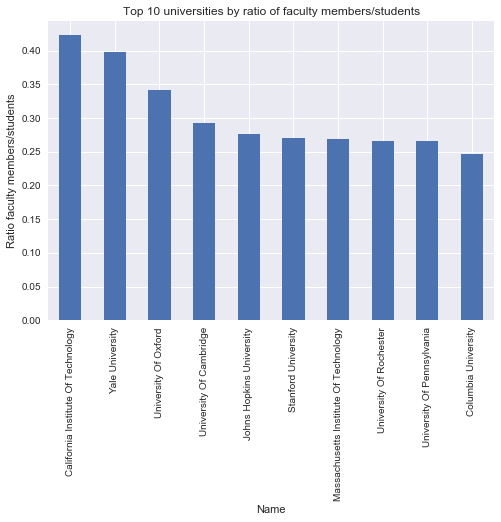

In [6]:
barplot = df_tu.sort_values(by=faculty_members_students_ratio, ascending=False).iloc[:10]\
    .plot.bar(x=name, y=faculty_members_students_ratio, legend=False);
barplot.set_title('Top 10 universities by ratio of faculty members/students')
barplot.set_xlabel(name)
barplot.set_ylabel(faculty_members_students_ratio);

We can see that all of the 10 universities belong to the english-speaking world - either American or English - so this could be a kind of anglophone university model that employs a considerable number of faculty members.

## Question b)
I sort the dataframe, compute the ratio as required and plot the 10 universities with the highest internationl students/total students ratio.

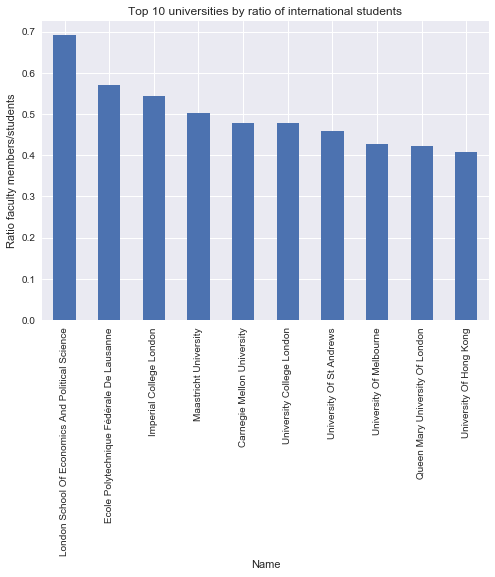

In [7]:
barplot = df_tu.sort_values(by=international_students_ratio, ascending=False).iloc[:10]\
    .plot.bar(x=name, y=international_students_ratio, legend=False);
barplot.set_title('Top 10 universities by ratio of international students')
barplot.set_xlabel(name)
barplot.set_ylabel(faculty_members_students_ratio);

It can be noticed that 7 out of 10 universities are European, and 4 of these 7 are based in London. It's also interesting to notice that EPFL is in the second position of this ranking, which means we are part of a very international campus.

## Question c)
### Faculty members and students ratio with country aggregation
To proceed, we grouped the dataframe by country, then computed the mean ratio.

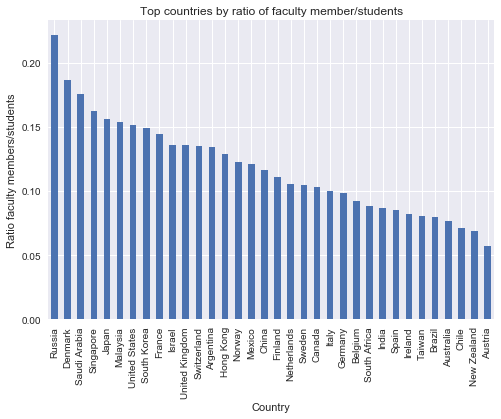

In [8]:
barplot = df_tu.groupby(country).mean().sort_values(faculty_members_students_ratio, ascending=False)\
    .plot.bar(y=faculty_members_students_ratio, legend=False)
barplot.set_title('Top countries by ratio of faculty member/students')
barplot.set_xlabel(country)
barplot.set_ylabel(faculty_members_students_ratio);

The results here are pretty different compared to question a) without aggregation: UK is at the 11th place while US is at the 7th place here, while the previous question highlighted the fact that the 10 universities with the highest faculty members/students ratio were American or English.

Let's look at the number of universities considered in the ranking for some countries:

In [9]:
num_uni_country('Russia')
num_uni_country('Denmark')
num_uni_country('United States')
num_uni_country('United Kingdom')

There are 1 universities in Russia
There are 3 universities in Denmark
There are 47 universities in United States
There are 28 universities in United Kingdom


We see that the two top ranked countries have only few universities, which means the sample may not be representative of the country actual ratio, but may instead consist of only the country 1-3 best universities.

Whereas for the UK and USA which were ranked very high previously, this shows that those top ranking universities were not really representative of the country's average university.

### International students ratio with country aggregation

To proceed, we grouped the dataframe by country, then computed the mean ratio.

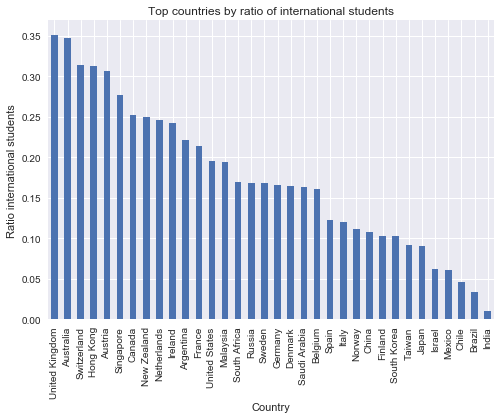

In [10]:
barplot = df_tu.groupby(country).mean().sort_values(international_students_ratio, ascending=False)\
    .plot.bar(y=international_students_ratio, legend=False)
barplot.set_title('Top countries by ratio of international students')
barplot.set_xlabel(country)
barplot.set_ylabel(international_students_ratio);

The results here are pretty coherent with the ones obtained without aggregating. We saw that 4 of the 10 universities with highest international students ratios were from London, and we can see that the UK is indeed at the first place of the country ranking. Melbourne University and Honk Kong University were also highly ranked, indeed Australia and Honk Kong are in second and fourth place. The presence of EPFL in the non-aggregated ranking is supported by Switzerland's 3rd place in the aggregated ranking. 

This general connivance could mean that the top universities of these countries are well renowned and therefore they attract international students.

## Question d)
### Faculty members and students ratio with region aggregation
To proceed we grouped the dataframe by region, then computed the mean for each region.

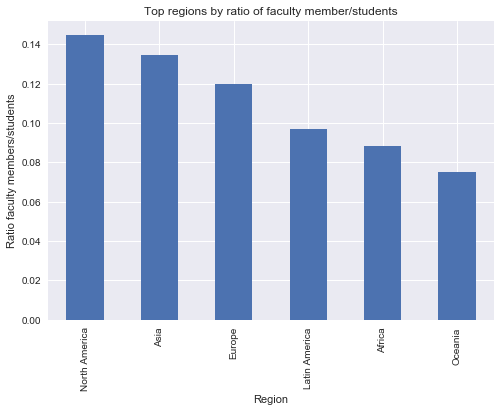

In [11]:
barplot = df_tu.groupby(region).mean().sort_values(faculty_members_students_ratio, ascending=False)\
    .plot.bar(y=faculty_members_students_ratio, legend=False)
barplot.set_title('Top regions by ratio of faculty member/students')
barplot.set_xlabel(region)
barplot.set_ylabel(faculty_members_students_ratio);

Unexpectedly North America is at the first place, even if US and Canada were not in the top places of the country ranking.
This could be explained by the fact that North America is only composed of the US and Canada, while the other regions are composed of many more countries which are distributed among the whole ranking.
For example, Europe includes countries which are both at the first and last place of the ranking - Russia and Austria. This reasoning is also coherent with Oceania's last positon, which results from New Zeland and Australia being among the last countries of the ranking.

### International students ratio with region aggregation
To proceed we grouped the dataframe by region, then computed the mean ratio.

The rank of Oceania and North America can again be explained by the fact that there are only two countries for these regions and that they scored well in the country ranking. This whole ranking in general is consistent with the country ranking.

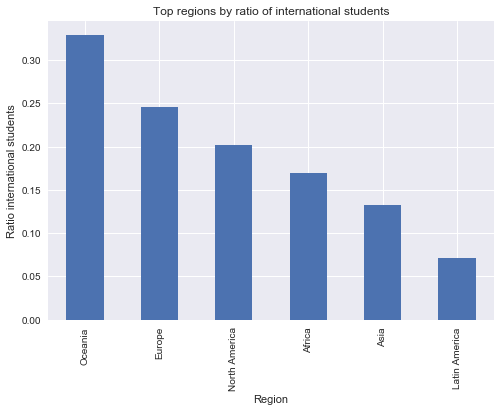

In [12]:
barplot = df_tu.groupby(region).mean().sort_values(international_students_ratio, ascending=False)\
    .plot.bar(y=international_students_ratio, legend=False)
barplot.set_title('Top regions by ratio of international students')
barplot.set_xlabel(region)
barplot.set_ylabel(international_students_ratio);

## Question 2: Times Higher Education webpage

This time again, using the Postman interceptor, we saw that the ranking was loaded from a json file. This time the json file contained all the data we needed, thus we took the first 200 universities and prepared the dataframe.

In [13]:
def prepare_uni_data_the(uni):
    uni_infos = dict()
    uni_infos['Name'] = map_name(normalize_name(uni['name']))
    uni_infos['Country'] = uni['location']
    uni_infos['Rank Time Higher Education'] = clean_number(uni['rank'])
    uni_infos['Number of Students'] = clean_number(uni['stats_number_students'])
    uni_infos['Student/Staff Ratio'] = clean_number(uni['stats_student_staff_ratio'])
    uni_infos['% of International Students'] = clean_number(uni['stats_pc_intl_students'])
    uni_infos[number_international_students] = uni_infos['% of International Students']/100*uni_infos['Number of Students']
    uni_infos[students_staff_ratio] = 1.0/uni_infos[students_staff_ratio]
    return uni_infos
res = get('https://www.timeshighereducation.com/sites/default/files/the_data_rankings/world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json', 'html')
json_ranking_the = json.loads(res.text)['data']
json_ranking_the = sorted(json_ranking_the, key=lambda k: clean_number(k['rank']))[:200]
df_the = pd.DataFrame(list(map(prepare_uni_data_the,json_ranking_the)))

def num_uni_country(country_name):
    print('There is', df_the[df_the[country] == country_name].shape[0], 'universities in', country_name)

### Question a)
We assumed that 'staff' meant faculty number. The ratio we have is the reverse of what we need, thus we compute the ratio of faculty members/student by inversing the students/staff ratio.

We then sort by the ratio, take the top 10 and plot it.
The results are of course different compared to the ones in part 1. US universities still dominate the board (7 out of 10), however there is the appearance of some european universities. A possible explanation is that most of these universities did not make it to the top 200 of the other ranking.

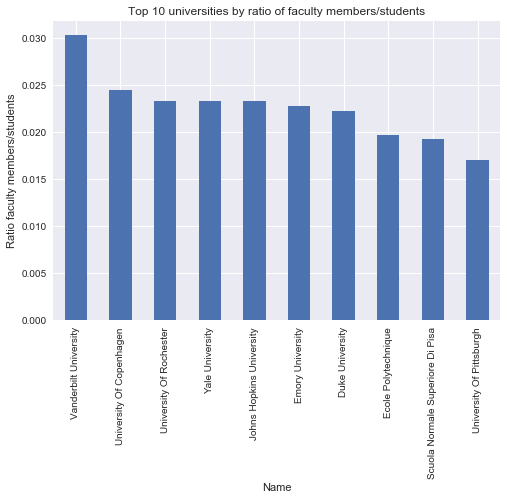

In [15]:
barplot = df_the.sort_values(by=faculty_members_students_ratio, ascending=False).iloc[:10]\
    .plot.bar(x=name, y=faculty_members_students_ratio, legend=False);
barplot.set_title('Top 10 universities by ratio of faculty members/students')
barplot.set_xlabel(name)
barplot.set_ylabel(faculty_members_students_ratio);

### Question b)
We sort the dataframe by using the values contained in the '% of international students" column.
The result are very similar to those of part 1: the same London universities as well as EPFL and Honk Kong University appears.

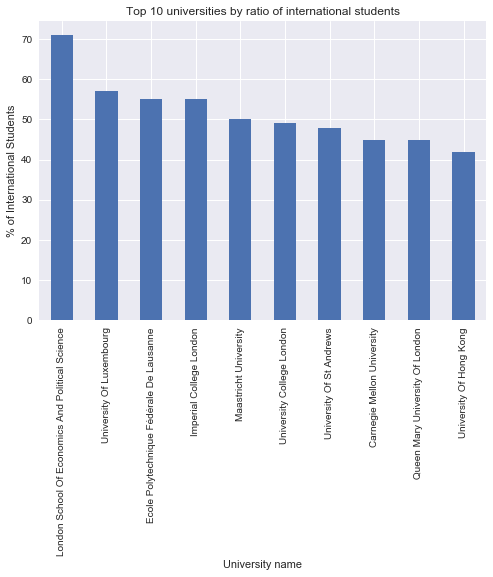

In [16]:
barplot = df_the.sort_values(by=pc_international_students, ascending=False).iloc[:10]\
    .plot.bar(x=name, y=pc_international_students, legend=False);
barplot.set_title('Top 10 universities by ratio of international students')
barplot.set_xlabel(university_name)
barplot.set_ylabel(pc_international_students);

## Question c)
### Faculty members and students ratio with country aggregation
We group by country and compute the mean ratio that we plot afterwards.

By comparing the university ranking with this newly obtained country ranking, we can observe general consistencies. For example, Denmark is high in the country ranking, and coherently in question a) we see that the University of Copenhagen is second place.

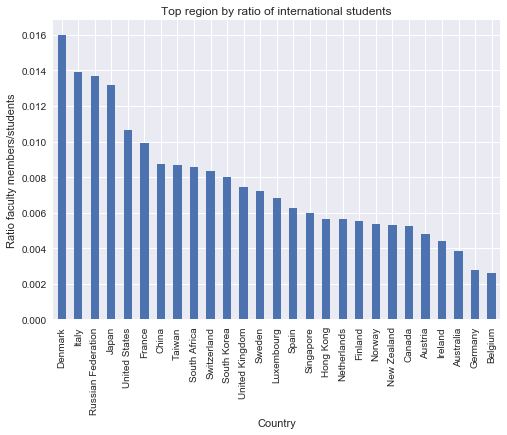

In [17]:
barplot = df_the.groupby(country).mean().sort_values(faculty_members_students_ratio, ascending=False)\
    .plot.bar(y=faculty_members_students_ratio, legend=False)
barplot.set_title('Top region by ratio of international students')
barplot.set_xlabel(country)
barplot.set_ylabel(faculty_members_students_ratio);

### International students ratio with country aggregation

Once again, we group by country and compute the mean ratio.

As the ranking obtained with country aggregation is similar to the previous one, the same analysis can be done.

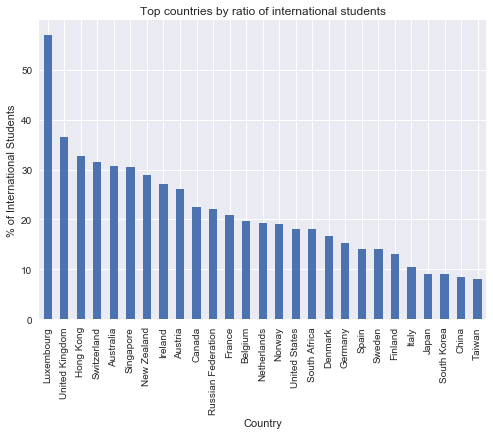

In [18]:
barplot = df_the.groupby(country).mean().sort_values(pc_international_students, ascending=False)\
    .plot.bar(y=pc_international_students, legend=False)
barplot.set_title('Top countries by ratio of international students')
barplot.set_xlabel(country)
barplot.set_ylabel(pc_international_students);

## Question d)

We map the countries using the mapping done in the top universities ranking.

In [19]:
country_to_region = df_tu[[country,region]].drop_duplicates().set_index(country).to_dict()['Region']
df_the[region] = df_the[country].map(country_to_region)

### Faculty members and students ratio with region aggregation
Once again, we group by region and compute the mean.
Similarly as in our previous results, with the respective university ranking, North America is in first place.

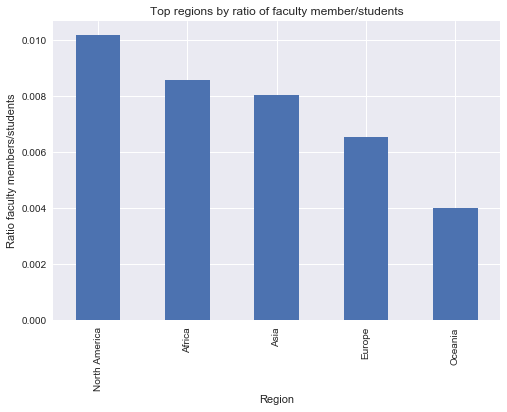

In [20]:
barplot = df_the.groupby(region).mean().sort_values(faculty_members_students_ratio, ascending=False)\
    .plot.bar(y=faculty_members_students_ratio, legend=False)
barplot.set_title('Top regions by ratio of faculty member/students')
barplot.set_xlabel(region)
barplot.set_ylabel(faculty_members_students_ratio);

### International students ratio with region aggregation

Continuously, the result shows that European and North American universities are at the top.

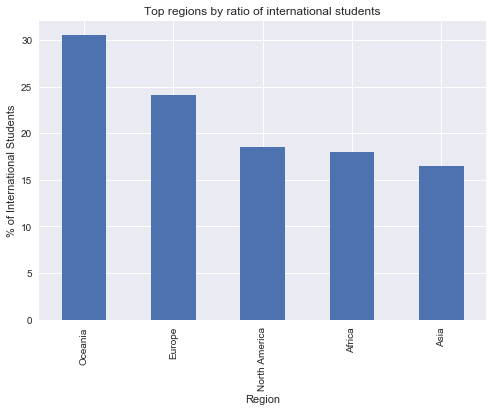

In [21]:
barplot = df_the.groupby(region).mean().sort_values(pc_international_students, ascending=False)\
    .plot.bar(y=pc_international_students, legend=False)
barplot.set_title('Top regions by ratio of international students')
barplot.set_xlabel(region)
barplot.set_ylabel(pc_international_students);

# Question 3: dataframes merging

We decided to only take the intersection of the two top 200 of the rankings. We tried to match as many name as possible using the 'map_name' function above.

To make an intersection between the two dataframes, we do an inner join.

In [22]:
merged_df = df_tu.merge(df_the, 'inner', on=['Name'])

# Question 4: Exploratory analysis

We create two helper functions to compute some correlations. We need those helper functions, because in some cases the variables are not numbers, that is the case for countries for example. In order to be able to use these variables, we transform them into enumerated type or categorical variables, using the functions 'factorize'.

In [23]:
#converts variable type into int so it's possible to compute correlation
def factorize(df, variable):
    labels, uniques = pd.factorize(df[variable])
    df[variable] = labels
    
#computes correlation and convert variable type if necessary
def compute_correlation(x_variable, y_variable, x_needs_factorization = False, y_needs_factorization = False):
    correlation_df = merged_df[[x_variable, y_variable]]
    if x_needs_factorization:
        factorize(correlation_df, x_variable)
    if y_needs_factorization:
        factorize(correlation_df, y_variable)
    return correlation_df.corr().values[0][1]

In [24]:
#further column names
countryx = 'Country_x'
regionx = 'Region_x'
international_faculty_members = 'International faculty members'
rank_tu = 'Rank Top Universities'
rank_the = 'Rank Time Higher Education'

The correlation between country and number of international students for the topUniversites ranking (TU ranking) is very low. That makes sense, knowing that there are renowned university a bit everywhere.

In [25]:
#correlation country-number of international students for tu
compute_correlation(countryx, international_students, x_needs_factorization = True)

-0.16598074314729033

Same as above for the Times Higher Education ranking (THE ranking).

In [26]:
#correlation country-number of international students for the
compute_correlation(countryx, number_international_students, x_needs_factorization = True)

-0.20758239457858058

The value of the correlation in this case justifies the hypothesis of a moderately high relationship between the number of international faculty members and number of international students. As a matter of fact, a university that is internationally recognized attracts both faculty members and students from abroad.

In [27]:
#correlation number of international faculty members - number of international students for tu
compute_correlation(international_faculty_members, international_students)

0.58051802475262637

The correlation between country and ranking for the TU ranking is low, suggesting there's no linear relationship between the two variables

In [28]:
#correlation country-ranking for tu
compute_correlation(countryx, rank_tu, x_needs_factorization = True)

0.35325266087653112

The correlation between country and ranking for the THE ranking website suggests a moderate linear relationship.

In [29]:
#correlation country-ranking for the
compute_correlation(countryx, rank_the, x_needs_factorization = True)

0.44049236971783623

The correlation between ranking and region is close to 0 for TU ranking. We therefore deduce there is no linear relationship.

In [30]:
#correlation region-ranking for tu
compute_correlation(regionx, rank_tu, x_needs_factorization = True)

-0.059616902632494792

The correlation between ranking and region is much higher for THE, which makes sense in regards of the higher country-ranking correlation.

In [31]:
#correlation region-ranking for the
compute_correlation(regionx, rank_the, x_needs_factorization = True)

0.31861024508211183

There's a tangible linear relationship between the number of faculty members and the number of students, which might be given by how big a university is: the bigger it is, the more students and faculty members it has.

In [32]:
#correlation total faculty members - total students for TU ranking
compute_correlation(total_faculty_members, total_students)
#kinda high correlation - makes sense

0.58846097194166191

There's a strong correlation between the TU and THE ranking, which makes sense since the ranking process should be a very objective one, and therefore both websites should rank universities in a similar way.

In [33]:
#correlation rank in first website - rank in second website
compute_correlation(rank_tu, rank_the)
# very high correlation thanks god - makes sense

0.69114609667868976

# Question 5: best university

In [34]:
#further column names
new_rank = 'New rank'
new_metric = 'New metric'
faculty_members_students_ratio_x = 'Ratio faculty members/students_x'
faculty_members_students_ratio_y = 'Ratio faculty members/students_y'

Here we decided to compute a new metric to compute the overall best ranking.
A simple but banal solution would be to simply use the average of the two rankings as the new metric, however we decided to do something more complex. We decided to incorporate the notions of "reasearch" and "internationality" in the new metric. We do this by computing an average of the international students ratio and faculty members/students ratio 
and adding them to the opposite of the averaged rank.
The reasonment behind this is that a university with a high presence of international students provides a richer and more diversified experience to the students - the dimension of "internationality" - while a university with a high faculty members ratio is more likely to focus on research and development and create new technologies - the dimension of "research". 
The new ranking obtained with this approach is consistent with the the previous results: renowned American and English universities are still at the top of the ranking, plus ETHZ and EPFL.

In [35]:
merged_df[new_metric] = 1.0/((merged_df[rank_tu]+merged_df[rank_the])/2)
merged_df[new_metric] += ((merged_df[pc_international_students]/100 + merged_df[international_students_ratio])/2)
merged_df[new_metric] += ((merged_df[faculty_members_students_ratio_x] + merged_df[faculty_members_students_ratio_x])/2)
new_rank_df = merged_df.sort_values(by=[new_metric], ascending=False).reset_index()
new_rank_df[new_rank] = new_rank_df.index + 1
# reduced_plot(mean_ranking_df, name, mean_rank, university_name, mean_rank)
new_rank_df[[name, new_rank, rank_tu, rank_the, new_metric]]

,Name,New rank,Rank Top Universities,Rank Time Higher Education,New metric
0,University Of Oxford,1,6,1,1.004441
1,California Institute Of Technology,2,4,3,0.986790
2,Massachusetts Institute Of Technology,3,1,5,0.940715
3,University Of Cambridge,4,5,2,0.931652
4,Imperial College London,5,8,8,0.916035
5,Stanford University,6,2,3,0.893581
6,London School Of Economics And Political Science,7,35,25,0.845505
7,University College London,8,7,16,0.775071
8,Ecole Polytechnique Fédérale De Lausanne,9,12,38,0.763903
9,Yale University,10,16,12,0.674292
